In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Параметры

In [2]:
latent_dim = 64
num_classes = 10
img_dim = 28 * 28
batch_size = 128
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка данных

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Модель Conditional VAE-GAN


In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(ConvEncoder, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Сверточные слои
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 1 канал для изображения
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))  # Приводим к размеру [batch_size, 256, 2, 2]

        # Полносвязные слои для mu и logvar
        self.fc_mu = nn.Linear(256 * 2 * 2 + num_classes, latent_dim)  # Добавляем метки к латентному вектору
        self.fc_logvar = nn.Linear(256 * 2 * 2 + num_classes, latent_dim)

    def forward(self, x, labels):
        # Применение сверточных слоев
        x = self.conv_layers(x)

        x = self.adaptive_pool(x)

        x = x.view(x.size(0), -1)  # Выравнивание для полносвязного слоя

        # Встраивание меток
        c = self.label_embedding(labels)

        # Конкатенация с латентным вектором
        x = torch.cat([x, c], dim=1)

        # Получение mu и logvar
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [ ]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(ConvDecoder, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Полносвязный слой для преобразования латентного вектора
        self.fc = nn.Linear(latent_dim + num_classes, 256 * 2 * 2)

        # Сверточные слои
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )


    def forward(self, z, labels):
        # Встраивание меток и конкатенация с латентным вектором
        c = self.label_embedding(labels)
        z = torch.cat([z, c], dim=1)

        # Преобразование в пространство для сверток
        x = self.fc(z)
        x = x.view(-1, 256, 2, 2)

        # Применение сверточных слоев
        x = self.conv_layers(x)
        return x

In [ ]:
class ConvDiscriminator(nn.Module):
    def __init__(self, num_classes):
        super(ConvDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Сверточные слои
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 1 канал для изображения
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )

        # Полносвязный слой для классификации
        self.fc = nn.Sequential(
            nn.Linear((256 + num_classes), 1),  # Добавляем метки к латентному вектору
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Применение сверточных слоев
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)

        # Встраивание меток
        c = self.label_embedding(labels)

        # Конкатенация с латентным вектором
        x = torch.cat([x, c], dim=1)

        x = x.view(x.size(0), -1)  # Выравнивание для полносвязного слоя

        # Классификация
        return self.fc(x)

# Инициализация моделей


In [7]:
encoder = ConvEncoder(latent_dim, num_classes).to(device)
decoder = ConvDecoder(latent_dim, num_classes).to(device)
discriminator = ConvDiscriminator(num_classes).to(device)

encoder.train()
decoder.train()
discriminator.train()

ConvDiscriminator(
  (label_embedding): Embedding(10, 10)
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=266, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Оптимизаторы


In [8]:
optimizer_E = optim.Adam(encoder.parameters(), lr=0.0002)
optimizer_D = optim.Adam(decoder.parameters(), lr=0.0005)
optimizer_Dis = optim.Adam(discriminator.parameters(), lr=0.00005)

# Функции потерь


In [9]:
criterion_gan = nn.BCELoss()
criterion_recon = nn.MSELoss()

# Обучение


In [10]:
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # ====== Обучение энкодера и декодера ======
        optimizer_E.zero_grad()
        optimizer_D.zero_grad()

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Кодирование
        mu, logvar = encoder(images, labels)
        z = mu + torch.exp(0.5 * logvar) * torch.randn_like(logvar)

        # Декодирование
        recon_images = decoder(z, labels)

        # Потери VAE
        loss_recon = criterion_recon(recon_images, images)
        loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss_vae = loss_recon + 0.0001 * loss_kl

        # Потери GAN
        fake_score = discriminator(recon_images, labels)
        loss_gan = criterion_gan(fake_score, real_labels)

        # Общий loss
        loss_E_D = loss_vae + loss_gan
        loss_E_D.backward()
        optimizer_E.step()
        optimizer_D.step()

        # ====== Обучение дискриминатора ======
        optimizer_Dis.zero_grad()

        # Потери на реальных данных
        real_score = discriminator(images, labels)
        loss_real = criterion_gan(real_score, real_labels)

        # Потери на фейковых данных
        fake_score = discriminator(recon_images.detach(), labels)
        loss_fake = criterion_gan(fake_score, fake_labels)

        # Общий loss
        loss_Dis = loss_real + loss_fake
        loss_Dis.backward()
        optimizer_Dis.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], "
                  f"Loss VAE: {loss_vae.item():.4f}, Loss GAN: {loss_gan.item():.4f}, "
                  f"Loss D: {loss_Dis.item():.4f}")

Epoch [0/20], Step [0/468], Loss VAE: 1.0970, Loss GAN: 0.6885, Loss D: 1.3921
Epoch [0/20], Step [100/468], Loss VAE: 0.4016, Loss GAN: 0.6484, Loss D: 1.5489
Epoch [0/20], Step [200/468], Loss VAE: 0.2443, Loss GAN: 0.6594, Loss D: 1.3596
Epoch [0/20], Step [300/468], Loss VAE: 0.2470, Loss GAN: 0.6384, Loss D: 1.3760
Epoch [0/20], Step [400/468], Loss VAE: 0.2431, Loss GAN: 0.6672, Loss D: 1.3760
Epoch [1/20], Step [0/468], Loss VAE: 0.2659, Loss GAN: 0.6735, Loss D: 1.3921
Epoch [1/20], Step [100/468], Loss VAE: 0.2526, Loss GAN: 0.6822, Loss D: 1.3867
Epoch [1/20], Step [200/468], Loss VAE: 0.2481, Loss GAN: 0.6924, Loss D: 1.3721
Epoch [1/20], Step [300/468], Loss VAE: 0.2515, Loss GAN: 0.6803, Loss D: 1.3770
Epoch [1/20], Step [400/468], Loss VAE: 0.2419, Loss GAN: 0.6897, Loss D: 1.3800
Epoch [2/20], Step [0/468], Loss VAE: 0.2519, Loss GAN: 0.6881, Loss D: 1.3803
Epoch [2/20], Step [100/468], Loss VAE: 0.2506, Loss GAN: 0.6862, Loss D: 1.3880
Epoch [2/20], Step [200/468], Loss

# Оценка модели

In [11]:
encoder.eval()
decoder.eval()
discriminator.eval()

ConvDiscriminator(
  (label_embedding): Embedding(10, 10)
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=266, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
total_loss_vae = 0
total_loss_gan = 0
total_loss_dis = 0
num_batches = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        batch_size = images.size(0)

        # Encoding и decoding
        mu, logvar = encoder(images, labels)
        z = mu + torch.exp(0.5 * logvar) * torch.randn_like(logvar)
        recon_images = decoder(z, labels)

        # Вычисляем потери
        loss_recon = criterion_recon(recon_images, images)
        loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss_vae = loss_recon + 0.00005 * loss_kl

        fake_score = discriminator(recon_images, labels)
        loss_gan = criterion_gan(fake_score, torch.ones(batch_size, 1).to(device))

        real_score = discriminator(images, labels)
        loss_real = criterion_gan(real_score, torch.ones(batch_size, 1).to(device))
        fake_score = discriminator(recon_images.detach(), labels)
        loss_fake = criterion_gan(fake_score, torch.zeros(batch_size, 1).to(device))
        loss_dis = loss_real + loss_fake

        # Пересчет суммы потерь
        total_loss_vae += loss_vae.item()
        total_loss_gan += loss_gan.item()
        total_loss_dis += loss_dis.item()
        num_batches += 1

# Вычисление средних потерь
avg_loss_vae = total_loss_vae / num_batches
avg_loss_gan = total_loss_gan / num_batches
avg_loss_dis = total_loss_dis / num_batches

print(f"Test Loss VAE: {avg_loss_vae:.4f}, Test Loss GAN: {avg_loss_gan:.4f}, Test Loss D: {avg_loss_dis:.4f}")

Test Loss VAE: 0.1665, Test Loss GAN: 0.6375, Test Loss D: 1.3753


# Генерация изображений


In [13]:
def generate_images(decoder, latent_dim, num_classes, device):
    with torch.no_grad():
        z = torch.randn(10, latent_dim).to(device)
        labels = torch.arange(0, 10).to(device)
        gen_images = decoder(z, labels).cpu()
        gen_images = gen_images * 0.5 + 0.5  # Денормализация
        return gen_images

# Визуализация


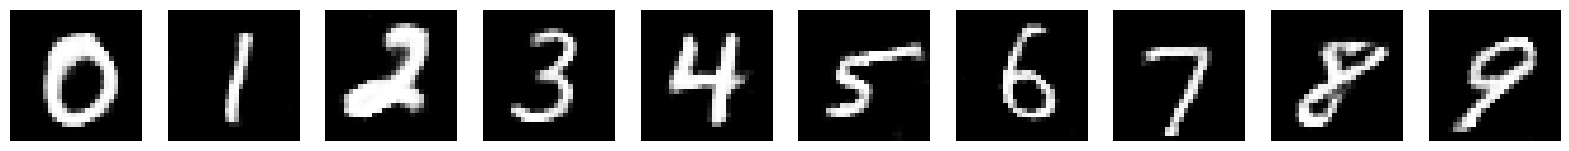

In [ ]:
gen_images = generate_images(decoder, latent_dim, num_classes, device)
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(gen_images[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.show()

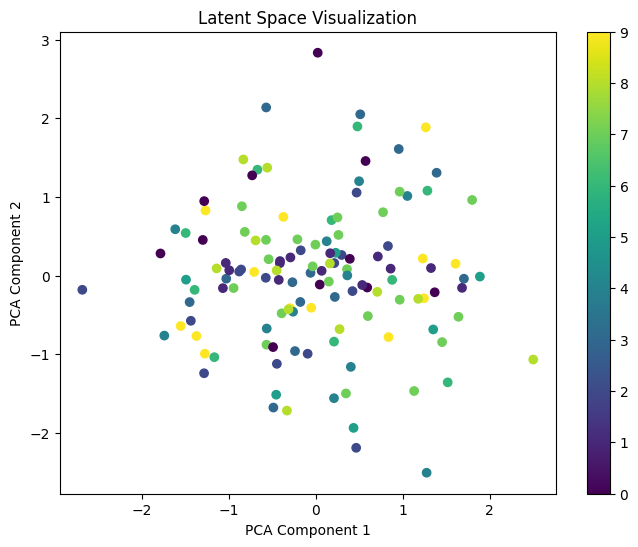

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Получаем латентное представление батча
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)
with torch.no_grad():
    mu, logvar = encoder(images, labels)
    z = mu

# Уменьшаем размерность до 2 с помощью PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z.cpu().numpy())

# Визуализируем
plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

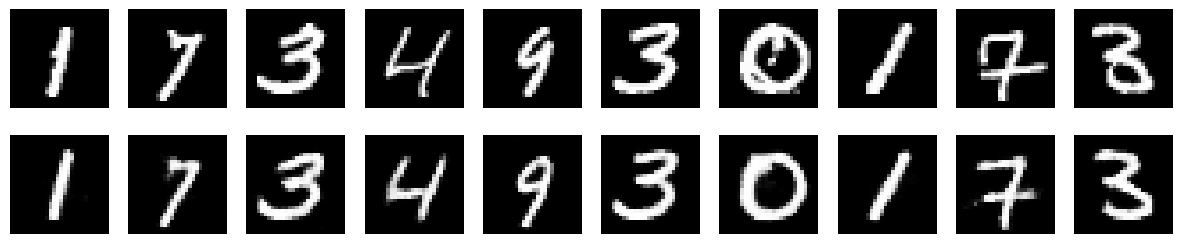

In [ ]:
# Восстанавливаем батч с помощью декодера
with torch.no_grad():
    recon_images = decoder(z, labels).cpu()

# Выводим оригинальное изображение и восстановленное
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(images[i].squeeze().cpu(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original')
axes[1, 0].set_ylabel('Reconstructed')
plt.show()

# Сохраняем обученную модель

In [17]:
import torch

encoder_path = 'encoder_model.pth'
decoder_path = 'decoder_model.pth'
discriminator_path = 'discriminator_model.pth'

torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)
torch.save(discriminator.state_dict(), discriminator_path)